1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
✅ A1_test.jpg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ A2_test.jpg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
✅ A_test.jpg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ B1_test.jpg — True: B, Predicted: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ B2_test.jpg — True: B, Predicted: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ B_test.jpg — True: B, Predicted: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
✅ C1_test.jpg — True: C, Predicted: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ C2_test.jpg — True: C, Predicted: Q
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ C_test.jpg — True: C, Predicted: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ D1_test.jpg — True: D, Predicted: Z
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ D2_test.jpg — True: D, Predicted: X
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ del2_test.jpg — True: del, Predicted: del
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
✅ del_test.jpg — True: del, Predicted: del
1/1

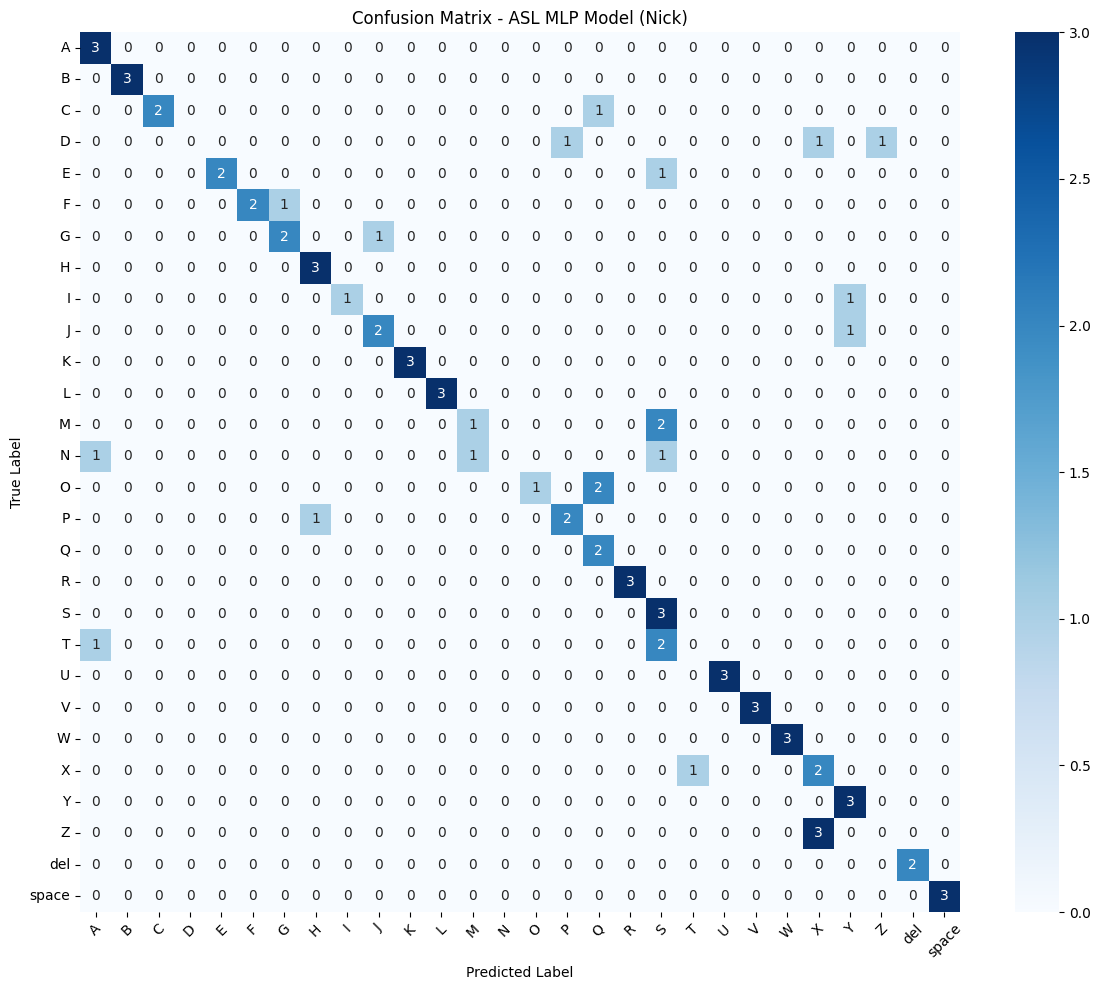


📋 Classification Report:
              precision    recall  f1-score   support

           A       0.60      1.00      0.75         3
           B       1.00      1.00      1.00         3
           C       1.00      0.67      0.80         3
           D       0.00      0.00      0.00         3
           E       1.00      0.67      0.80         3
           F       1.00      0.67      0.80         3
           G       0.67      0.67      0.67         3
           H       0.75      1.00      0.86         3
           I       1.00      0.50      0.67         2
           J       0.67      0.67      0.67         3
           K       1.00      1.00      1.00         3
           L       1.00      1.00      1.00         3
           M       0.50      0.33      0.40         3
           N       0.00      0.00      0.00         3
           O       1.00      0.33      0.50         3
           P       0.67      0.67      0.67         3
           Q       0.40      1.00      0.57         2
 

C:\Users\shree\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shree\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shree\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [2]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import mediapipe as mp

# Load model and label encoder
model = load_model('asl_cnn_2D_model.h5')

with open("label_encoder.pickle", "rb") as f:
    label_encoder = pickle.load(f)

CLASS_NAMES = list(label_encoder.classes_)

# Mediapipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.5)

# Image directory
IMAGE_FOLDER_PATH = r"ASL_Alphabet_Dataset\NickDataset"

# Storage
true_labels = []
predicted_labels = []

for image_name in os.listdir(IMAGE_FOLDER_PATH):
    image_path = os.path.join(IMAGE_FOLDER_PATH, image_name)

    if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    # Extract true label
    filename = os.path.splitext(image_name)[0]
    if "_" not in filename:
        print(f"Skipping file (no underscore): {image_name}")
        continue

    raw_label = filename.split('_')[0]
    true_label = ''.join([c for c in raw_label if not c.isdigit()])

    if true_label not in CLASS_NAMES:
        print(f"Skipping unknown class: {true_label} in {image_name}")
        continue

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for point in hand_landmarks.landmark:
                landmarks.append(point.x)
                landmarks.append(point.y)

            if len(landmarks) < 42:
                print(f"Incomplete landmarks in {image_name}")
                continue

            input_data = np.array(landmarks[:42]).reshape(1, -1)
            prediction = model.predict(input_data)
            predicted_index = np.argmax(prediction, axis=1)[0]
            predicted_label = CLASS_NAMES[predicted_index]

            print(f"✅ {image_name} — True: {true_label}, Predicted: {predicted_label}")

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)

# Accuracy & Confusion Matrix
if true_labels and predicted_labels:
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\n✅ Model Accuracy: {accuracy:.4f}")

    labels_sorted = sorted(set(true_labels + predicted_labels))
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels_sorted)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - ASL MLP Model (Nick)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("\n📋 Classification Report:")
    print(classification_report(true_labels, predicted_labels, labels=labels_sorted))
else:
    print("❌ No valid predictions were made.")
